## **Install Libraries**

In [82]:
!pip install geopandas

## **Import Libraries**

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

sns.set_palette("Set2")
sns.set_style("ticks")

## **Import Data**

In [0]:
crimes = pd.read_csv("https://github.com/fescobar96/Crime-Prediction-in-San-Francisco/raw/master/Data/train.zip")

In [0]:
weather = pd.read_csv("https://raw.githubusercontent.com/fescobar96/Crime-Prediction-in-San-Francisco/master/Data/sf_weather.csv")

## **Data Preprocessing - San Francisco Crimes**

In [86]:
crimes_missing = pd.DataFrame(crimes.isnull().mean()*100, columns=["Missing Values %"])
crimes_missing

,Missing Values %
Dates,0.0
Category,0.0
Descript,0.0
DayOfWeek,0.0
PdDistrict,0.0
Resolution,0.0
Address,0.0
X,0.0
Y,0.0


In [0]:
crimes_original = crimes.copy()
crimes_original["Dates"] = pd.to_datetime(crimes["Dates"])
crimes_original.set_index(keys=crimes_original["Dates"], inplace=True)
crimes_original.drop(columns=["Dates"], inplace=True)

In [0]:
crimes.drop(columns=["Category", "Descript", "Resolution", "Address", "X", "Y"], inplace=True)

In [0]:
crimes["Dates"] = pd.to_datetime(crimes["Dates"]).dt.date

In [90]:
crimes.head()

,Dates,DayOfWeek,PdDistrict
0,2015-05-13,Wednesday,NORTHERN
1,2015-05-13,Wednesday,NORTHERN
2,2015-05-13,Wednesday,NORTHERN
3,2015-05-13,Wednesday,NORTHERN
4,2015-05-13,Wednesday,PARK


## **Data Preprocessing - Weather**

In [91]:
weather_missing = pd.DataFrame(weather.isnull().mean()*100, columns=["Missing Values %"])
weather_missing

,Missing Values %
date,0.0
avg_temp (celsius),0.0
precipitation (mm),0.0
wind_speed (km/h),0.0
visibility (km),0.0
"moon_illumination, %",0.0


In [0]:
weather["Dates"] = pd.to_datetime(weather["date"]).dt.date

In [0]:
weather_original = weather.copy()
weather_original["Dates"] = pd.to_datetime(weather["Dates"])
weather_original.set_index(keys=weather_original["Dates"], inplace=True)
weather_original.drop(columns=["Dates"], inplace=True)

In [0]:
weather.drop(columns=["date", "moon_illumination, %"], inplace=True)

In [95]:
weather.head()

,avg_temp (celsius),precipitation (mm),wind_speed (km/h),visibility (km),Dates
0,9,0.00,3,15.0,2003-01-01
1,10,0.00,5,15.0,2003-01-02
2,10,0.00,5,15.0,2003-01-03
3,11,0.00,5,15.0,2003-01-04
4,11,0.25,5,6.0,2003-01-05


Merge crimes and weather dataframes

In [0]:
data=pd.merge(crimes, weather, how="left", on="Dates")
data["Dates"] = pd.to_datetime(data["Dates"])
data.set_index(keys=data["Dates"], inplace=True)
data.drop(columns=["Dates"], inplace=True)

In [0]:
data.rename(columns={"avg_temp (celsius)":"avg_temp",
             "precipitation (mm)":"precipitation",
             "wind_speed (km/h)":"wind_speed",
             "visibility (km)":"visibility"
             }, inplace=True)

In [98]:
data.head()

,DayOfWeek,PdDistrict,avg_temp,precipitation,wind_speed,visibility
Dates,,,,,,
2015-05-13,Wednesday,NORTHERN,15,0.00,19,40.0
2015-05-13,Wednesday,NORTHERN,15,0.00,19,40.0
2015-05-13,Wednesday,NORTHERN,15,0.00,19,40.0
2015-05-13,Wednesday,NORTHERN,15,0.00,19,40.0
2015-05-13,Wednesday,PARK,15,0.00,19,40.0


### **Crimes by Year**

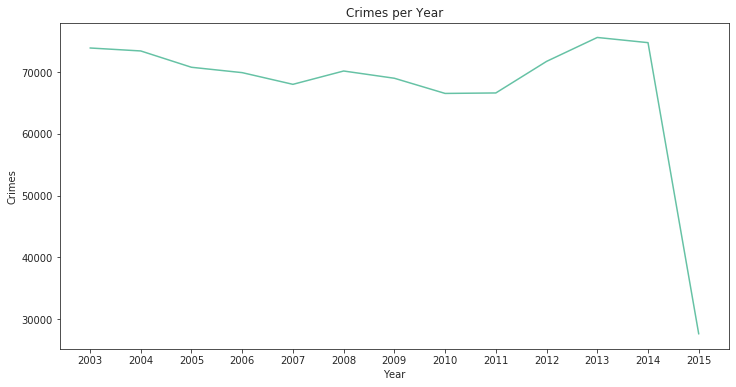

In [99]:
plt.figure(figsize=(12,6))
yearly_crimes = data["DayOfWeek"].resample("Y").count()
years = [x for x in range(2003, 2016)]
sns.lineplot(x=years, y=yearly_crimes.values)
plt.xlabel("Year")
plt.ylabel("Crimes")
plt.xticks(years, years)
plt.title("Crimes per Year")
plt.show()

### **Crimes by Day of the Week**

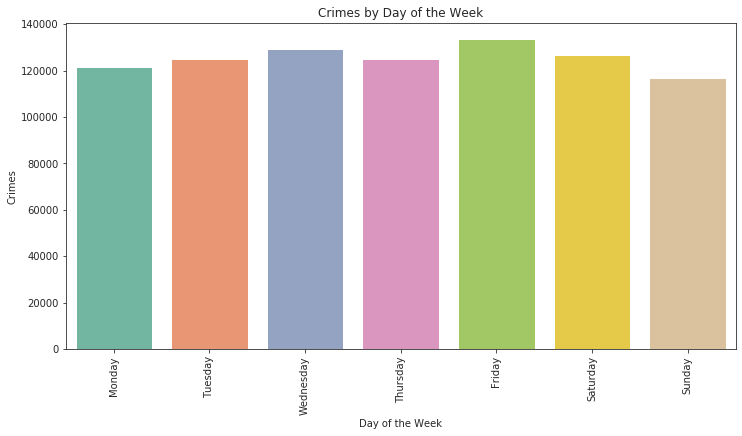

In [100]:
plt.figure(figsize=(12,6))
sns.countplot(x="DayOfWeek", data=data, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Crimes by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Crimes")
plt.xticks(rotation=90)
plt.show()

### **Crimes per Hour**

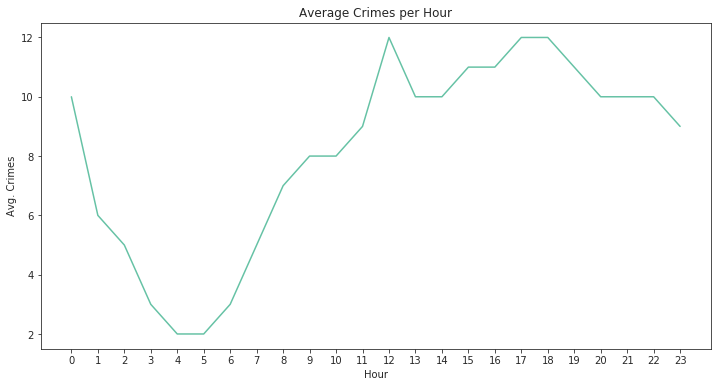

In [101]:
plt.figure(figsize=(12,6))
hourly_crimes = crimes_original["DayOfWeek"].resample("H").count()
hours = [x for x in range(0, 24)]
hourly_crimes = round(hourly_crimes.groupby(hourly_crimes.index.hour).mean(), 0)
hourly_crimes.values
sns.lineplot(x=hours, y=hourly_crimes.values)
plt.xlabel("Hour")
plt.ylabel("Avg. Crimes")
plt.title("Average Crimes per Hour")
plt.xticks(hours, hours)
plt.show()

### **Crimes by Category**

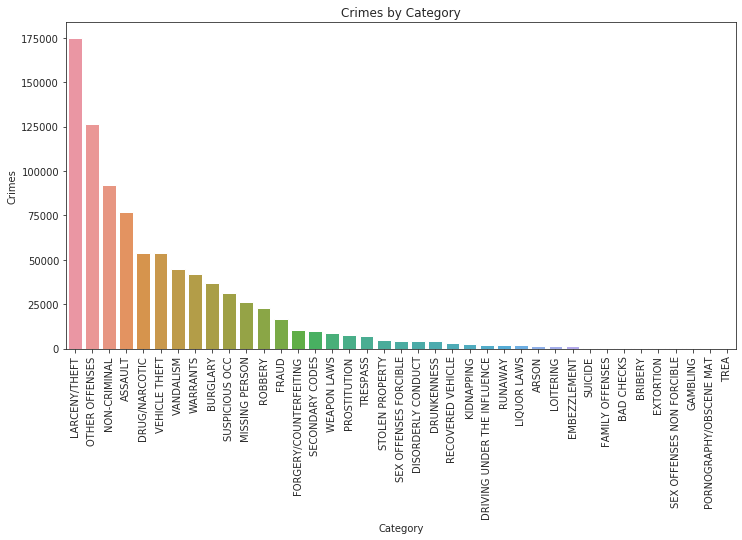

In [102]:
plt.figure(figsize=(12,6))
sns.countplot(x="Category", data=crimes_original, order=crimes_original["Category"].value_counts().index)
plt.title("Crimes by Category")
plt.ylabel("Crimes")
plt.xticks(rotation=90)
plt.show()

### **Crimes by Police Department District**

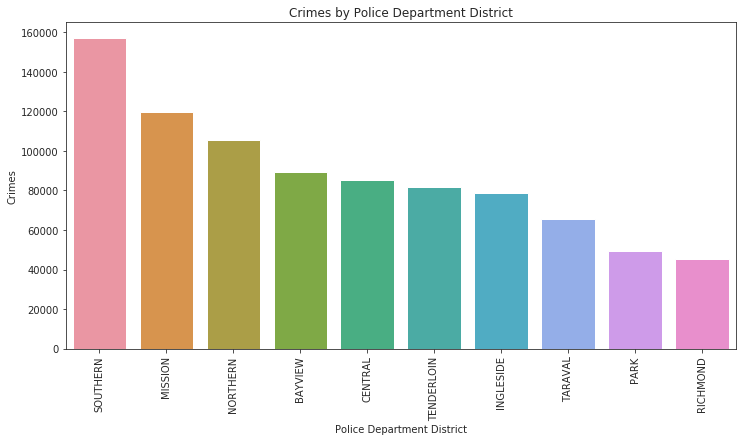

In [103]:
plt.figure(figsize=(12,6))
sns.countplot(x="PdDistrict", data=crimes_original, order=crimes_original["PdDistrict"].value_counts().index)
plt.xlabel("Police Department District")
plt.ylabel("Crimes")
plt.title("Crimes by Police Department District")
plt.xticks(rotation=90)
plt.show()

### **Crimes by Resolutions**

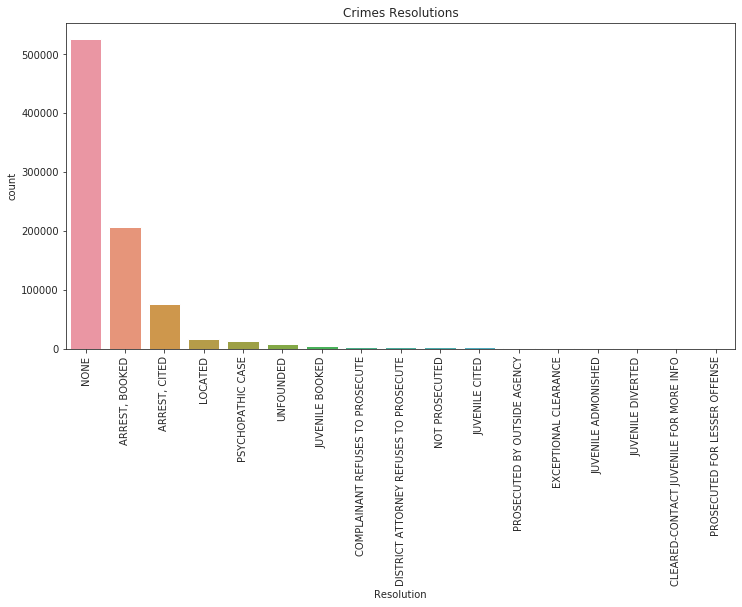

In [104]:
plt.figure(figsize=(12,6))
sns.countplot(x="Resolution", data=crimes_original, order=crimes_original["Resolution"].value_counts().index)
plt.title("Crimes Resolutions")
plt.xticks(rotation=90)
plt.show()

group by temperature get mean crime

In [105]:
data.groupby(by="avg_temp")

In [106]:
data

,DayOfWeek,PdDistrict,avg_temp,precipitation,wind_speed,visibility
Dates,,,,,,
2015-05-13,Wednesday,NORTHERN,15,0.00,19,40.0
2015-05-13,Wednesday,NORTHERN,15,0.00,19,40.0
2015-05-13,Wednesday,NORTHERN,15,0.00,19,40.0
2015-05-13,Wednesday,NORTHERN,15,0.00,19,40.0
2015-05-13,Wednesday,PARK,15,0.00,19,40.0
...,...,...,...,...,...,...
2003-01-06,Monday,TARAVAL,14,0.00,13,16.0
2003-01-06,Monday,INGLESIDE,14,0.00,13,16.0
2003-01-06,Monday,SOUTHERN,14,0.00,13,16.0
